# San Francisco Crime Classification

**Authors**: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [12]:
%%capture
!pip install scikit-learn
!pip install geopandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.functions import *

from pyspark.ml import Pipeline

from pyspark.ml.feature import *

from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, LogisticRegression, RandomForestClassifier, GBTClassifier, FMClassifier, OneVsRest, MultilayerPerceptronClassifier
 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Fix seed for reproducibility
seed = 1234


In [3]:
#Geopandas
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Load the data

In [5]:
def load_data(split):
    df = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/dataset/{split}.csv").load()
    return df

In [6]:
df_sfcrime = load_data("train")
df_sfcrime.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [6]:
# Visualize the data
df_sfcrime.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

**Data fields**:
- *Dates*: timestamp of the crime incident.
- *Category*: category of the crime incident. **Target variable** we are going to predict.
- *Descript*: detailed description of the crime incident.
- *DayOfWeek*: the day of the week.
- *PdDistrict*: name of the Police Department District.
- *Resolution*: how the crime incident was resolved.
- *Address*: the approximate street address of the crime incident.
- *X*: longitude.
- *Y*: latitude.

## Data Preprocessing

Steps done in preprocessing:
- **Feature extraction**: extract Hour, Month, and Year from the 'Dates' column in the DataFrame.
- **Drop duplicate rows**
- **Nulls removal**
- **Outliers removal**: filter out outliers based on specified criteria for latitude and longitude values ('X' and 'Y' coordinates).
- **Normalize coordinates**: normalize 'X' and 'Y' coordinates using MinMaxScaler to transform the values between 0 and 1.
- **Drop unused columns**

In [8]:
def plot_outliers(df):
    sfcrime_pd = df.toPandas()

    geometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]
    gdf = GeoDataFrame(sfcrime_pd, geometry=geometry)

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(), marker='o', color='red')
    plt.show()

In [7]:
# Extract features from date 
df_sfcrime = df_sfcrime.withColumn('Hour', hour("Dates"))\
        .withColumn('Month', month("Dates"))\
        .withColumn('Year', year("Dates"))

# Drop duplicate rows
prev_count = df_sfcrime.count()
df_sfcrime = df_sfcrime.dropDuplicates()
print(f"Number of duplicated rows: ", prev_count - df_sfcrime.count())

# Nulls removal
df_sfcrime.na.drop()

# Outliers removal
plot_outliers(df_sfcrime) 
prev_count = df_sfcrime.count()
df_sfcrime = df_sfcrime.where((df_sfcrime.X < -122) & (df_sfcrime.X > -123) & (df_sfcrime.Y < 38) & (df_sfcrime.Y > 37))
print(f"Number of outliers: ", prev_count - df_sfcrime.count())
    
# Normalize X and Y coordinates 
for i in ["X","Y"]:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    pipeline = Pipeline(stages=[assembler, scaler])
    df_sfcrime = pipeline.fit(df_sfcrime).transform(df_sfcrime)

# Drop unused columns
df_sfcrime = df_sfcrime.drop("Dates")
df_sfcrime = df_sfcrime.drop("X_Vect","Y_Vect", "X", "Y")

# Visualize the data
df_sfcrime.show()

Number of duplicated rows:  2323


Number of outliers:  67


+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|Hour|Month|Year|            X_Scaled|            Y_Scaled|
+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      BURGLARY|BURGLARY, UNLAWFU...|Wednesday|  NORTHERN|          NONE|2300 Block of FIL...|  13|    5|2015|[0.5331389416346913]|[0.7428616292488223]|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|  Tuesday| INGLESIDE|          NONE|ALEMANY BL / ONON...|  21|    5|2015|[0.5043534508595877]|[0.12263853306963...|
| LARCENY/THEFT|GRAND THEFT FROM ...|   Monday|  NORTHERN|          NONE|   BUSH ST / POLK ST|  21|    5|2015|[0.6276519170675439]|[0.7209854943264132]|
| LARCENY/THEFT|GRAND THEFT SHOPL...|   Monday|  SOUTHERN|          NONE|700 Block

From the previous image, we can observe that there are some erroneus coordinates that do not refer to San Francisco geographic coordinates. They may be due to mislabelling errors, and we consider them as outliers, therefore we remove them from the dataset. 

## Dataset inspection

In [11]:
# Split the data into train and test (to inspect only the train set)
sfcrime_train, sfcrime_test = df_sfcrime.randomSplit([0.7, 0.3], seed=seed)

In [12]:
plot = True
if plot:
    sfcrime_train_pd = sfcrime_train.toPandas().copy()
    
    # Select the top 10 crimes and group the rest into 'Other crimes'
    top10 = sfcrime_train_pd['Category'].value_counts().head(10).index.tolist()
    sfcrime_train_top_10 = sfcrime_train_pd.copy()
    sfcrime_train_top_10.loc[~sfcrime_train_pd['Category'].isin(top10), 'Category'] = 'Other crimes'


### Distribution of crimes

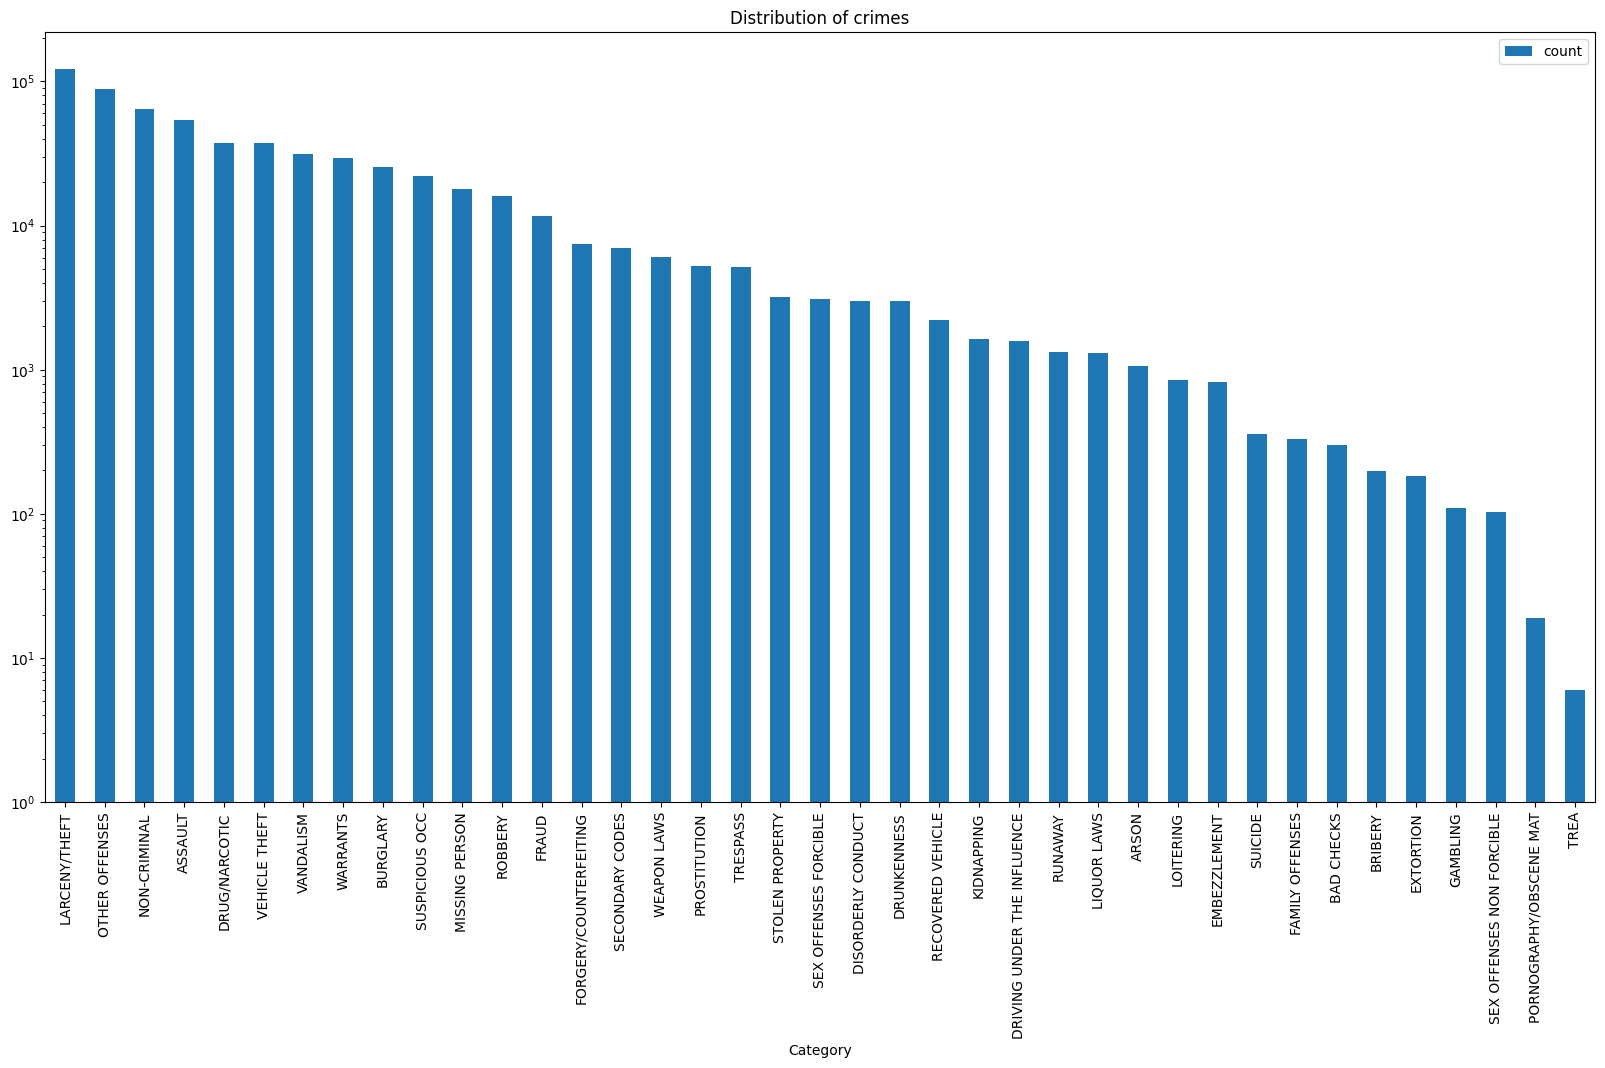

In [13]:
def crime_distribution(df, plot = True):
    if plot:
        df.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
        plt.title('Distribution of crimes')
        plt.show()

crime_distribution(sfcrime_train, plot = plot)    

### Distributions of crimes among districts

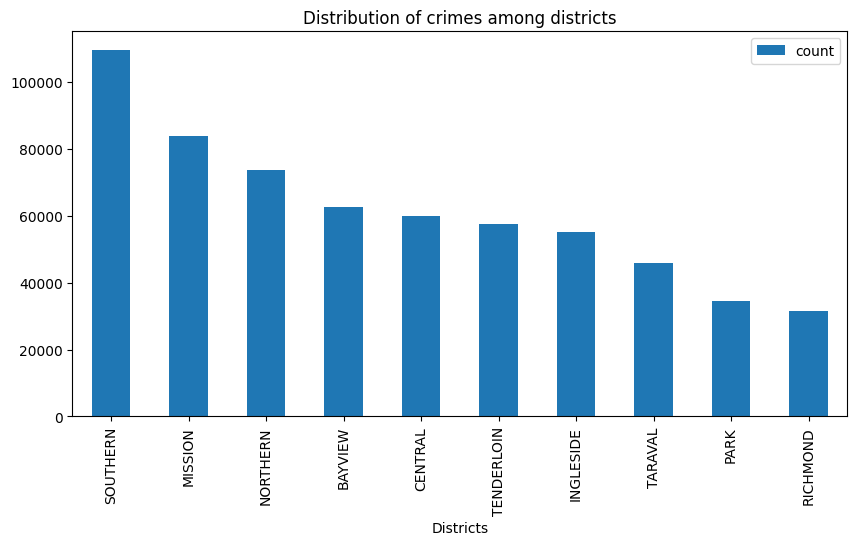

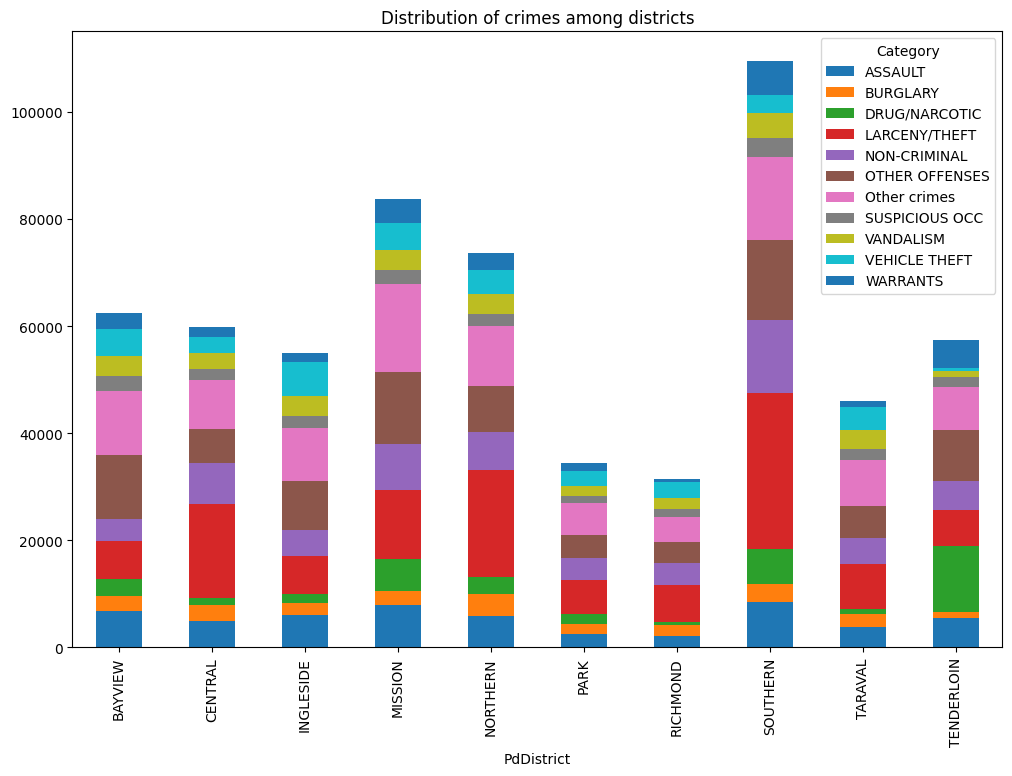

In [14]:
def crime_distribution_among_districts(df, df_copy_top_10, plot = True):
    if plot:
        '''df.groupBy("PdDistrict").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='PdDistrict', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among districts')
        plt.xlabel('Districts')
        plt.show()'''
        
        # Analyze the different categories of crimes per district
        df_copy_top_10.groupby(['PdDistrict','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))
        plt.title('Distribution of crimes among districts')

crime_distribution_among_districts(sfcrime_train, sfcrime_train_top_10, plot = plot)

### Distribution of crimes among years

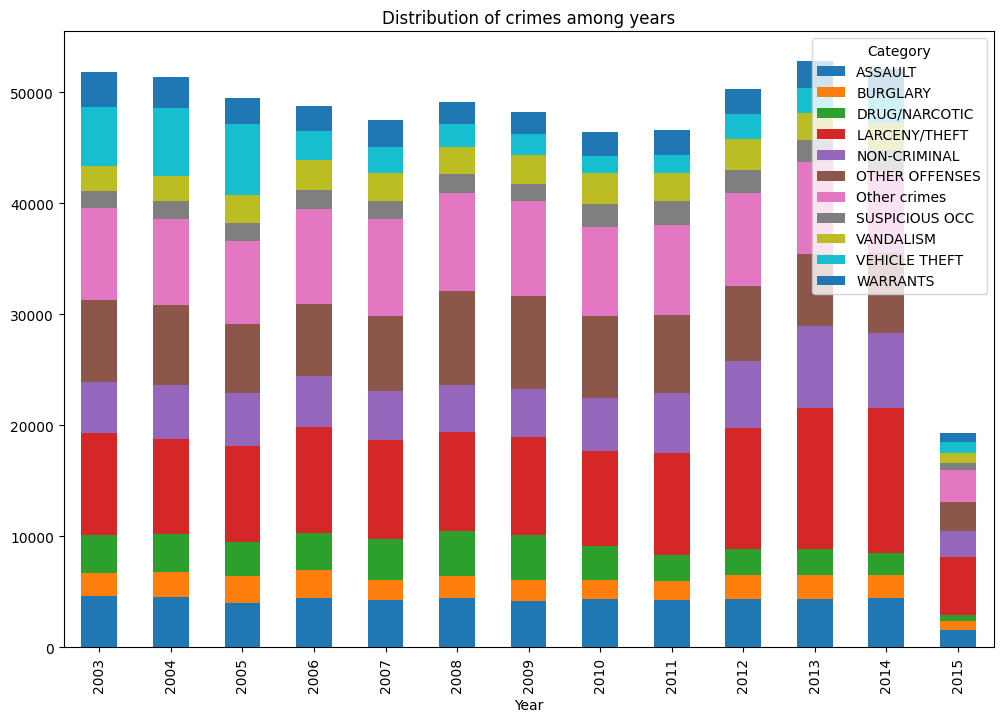

In [15]:
def crime_distribution_among_years(df_copy_top_10, plot = True):
    if plot:
        df_copy_top_10.groupby(['Year','Category'])\
                        .agg({'Resolution':'count'})\
                        .pivot_table(index='Year',columns='Category')['Resolution']\
                        .plot(kind='bar',stacked=True,figsize=(12,8))

        plt.title('Distribution of crimes among years')
        plt.show()

crime_distribution_among_years(sfcrime_train_top_10, plot = plot)

The decrease in the number of crimes observed in 2015 may be due to the dataset's limitations, which only encompass crimes until May 2015. This may have resulted in a lower count for that year.

### Distribution of crimes among hours

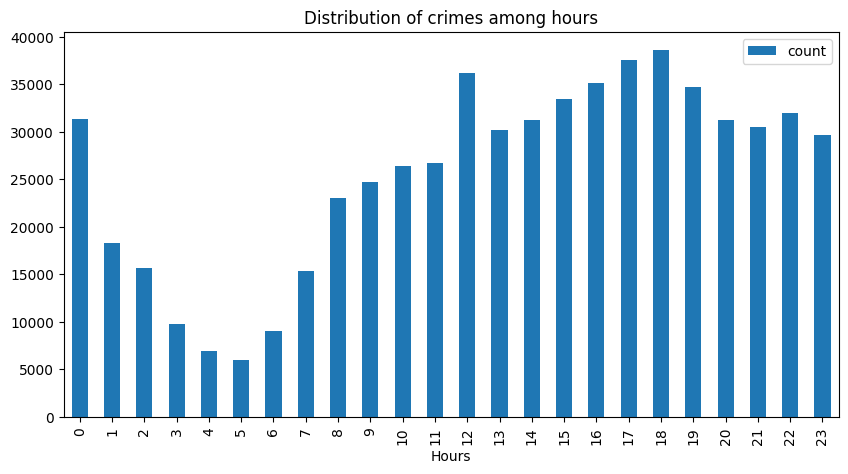

In [16]:
def crime_distribution_among_hours(df, plot = True):
    if plot:
        df.groupBy("Hour").count().orderBy("hour", ascending=True).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among hours')
        plt.xlabel('Hours')
        plt.show()

crime_distribution_among_hours(sfcrime_train, plot = plot)

### Distribution of crimes among days

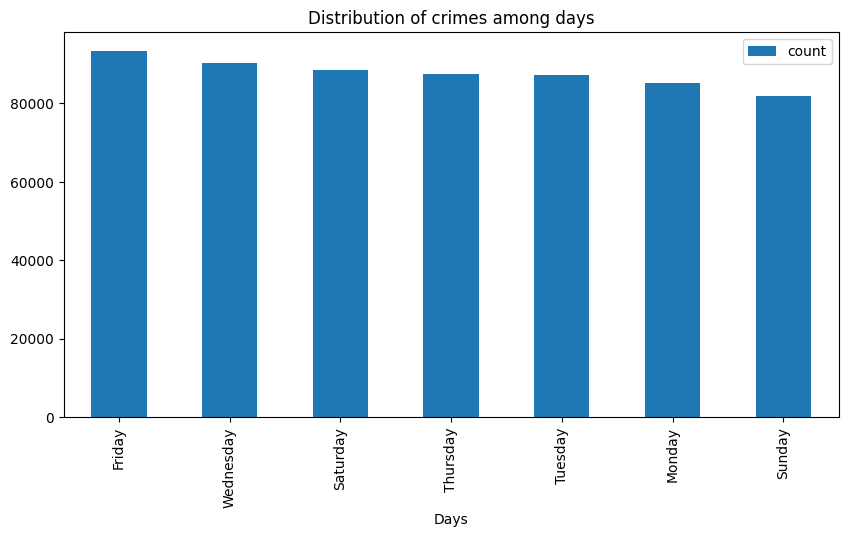

In [17]:
def crime_distribution_among_days(df, plot = True):
    if plot:
        df.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
        plt.title('Distribution of crimes among days')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_days(sfcrime_train, plot = plot)

### Trends of crimes during the week -- TODO: scrivere se si evidenzia qualche trend

In [ ]:
# TODO: vedere se ok
def weekly_trend(df, categories):
    fig, axs = plt.subplots(2, 3, figsize=(8, 5))
    axs = axs.flatten()
    
    for i, category in enumerate(categories):
        sfcrime_category = df[df['Category'] == category]
        category_counts = sfcrime_category.groupby(['DayOfWeek', 'Category']) \
                                            .agg({'Resolution': 'count'}) \
                                            .pivot_table(index='DayOfWeek', columns='Category')['Resolution'] \
                                            .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        
        ax = axs[i]
        category_counts.plot(kind='line', ax=ax)
        ax.set_title('Weekly trend of the category: ' + category)
        ax.set_xlabel('Day of the week')
        ax.set_ylabel('Count')
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'df' is your DataFrame and 'categories' is a list of six categories
# categories = ['Category1', 'Category2', 'Category3', 'Category4', 'Category5', 'Category6']
# weekly_trend(df, categories)
def plot_trends(df, categories, plot = True):
    if plot:        
        weekly_trend(df, categories)


In [ ]:
categories = ['DRIVING UNDER THE INFLUENCE', 'SUICIDE', 'LARCENY/THEFT', 'ASSAULT', 'DRUG/NARCOTIC', 'VEHICLE THEFT']

plot_trends(sfcrime_train_pd, categories, plot = plot)

In [18]:
'''def weekly_trend(df, category):
    sfcrime_category = df[df['Category']==category]
    sfcrime_category.groupby(['DayOfWeek','Category'])\
                .agg({'Resolution':'count'})\
                .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
                .plot(kind='line',figsize=(8,5))
    plt.title('Weekly trend of the category: ' + category)
    plt.xlabel('Day of the week')
    plt.ylabel('Count')
    plt.show()

def plot_trend(df, category, plot = True):
    if plot:        
        weekly_trend(df, category)'''

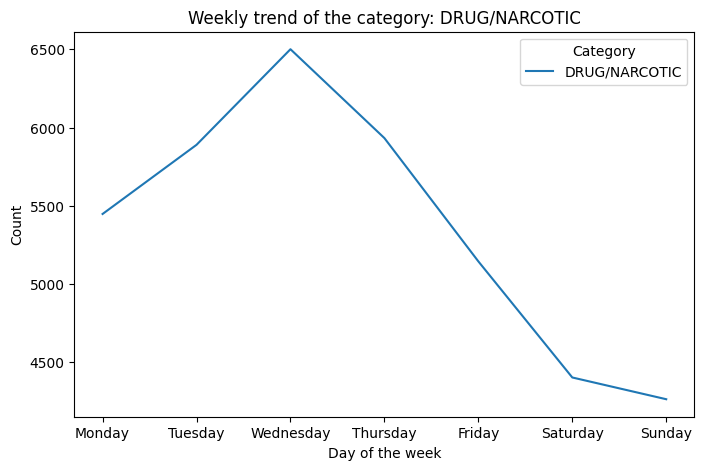

In [19]:
#plot_trend(sfcrime_train_pd, 'DRUG/NARCOTIC', plot = plot)

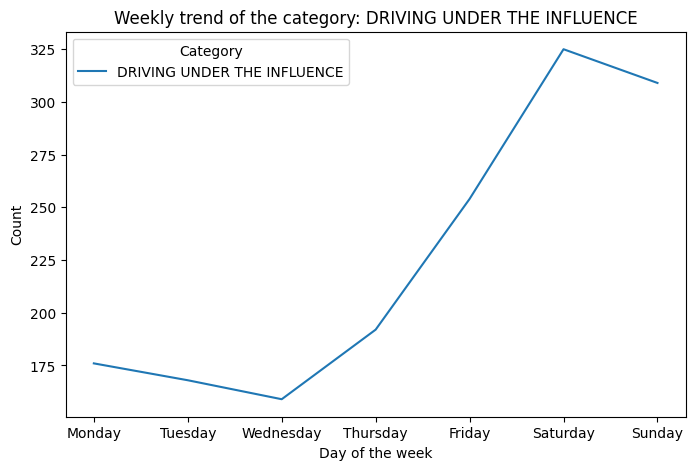

In [20]:
#plot_trend(sfcrime_train_pd, 'DRIVING UNDER THE INFLUENCE', plot = plot)

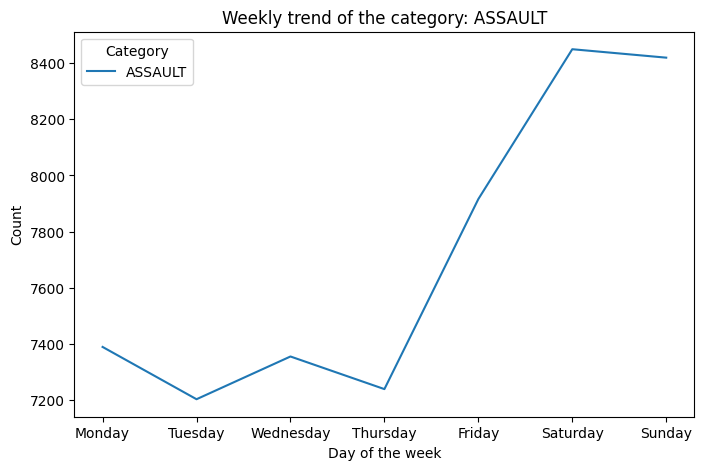

In [21]:
#plot_trend(sfcrime_train_pd, 'ASSAULT', plot = plot)

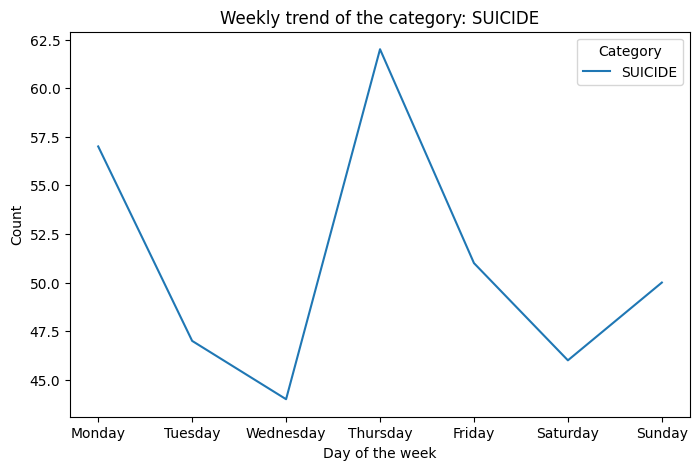

In [22]:
#plot_trend(sfcrime_train_pd, 'SUICIDE', plot = plot)

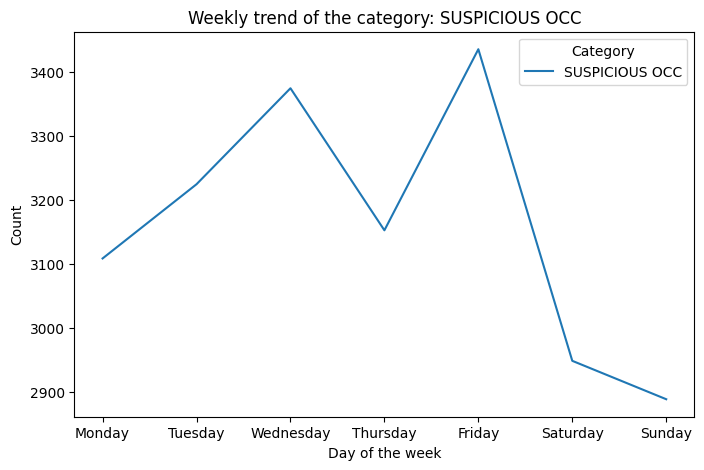

In [23]:
#plot_trend(sfcrime_train_pd, 'SUSPICIOUS OCC', plot = plot)

### Distribution of crimes among different addresses

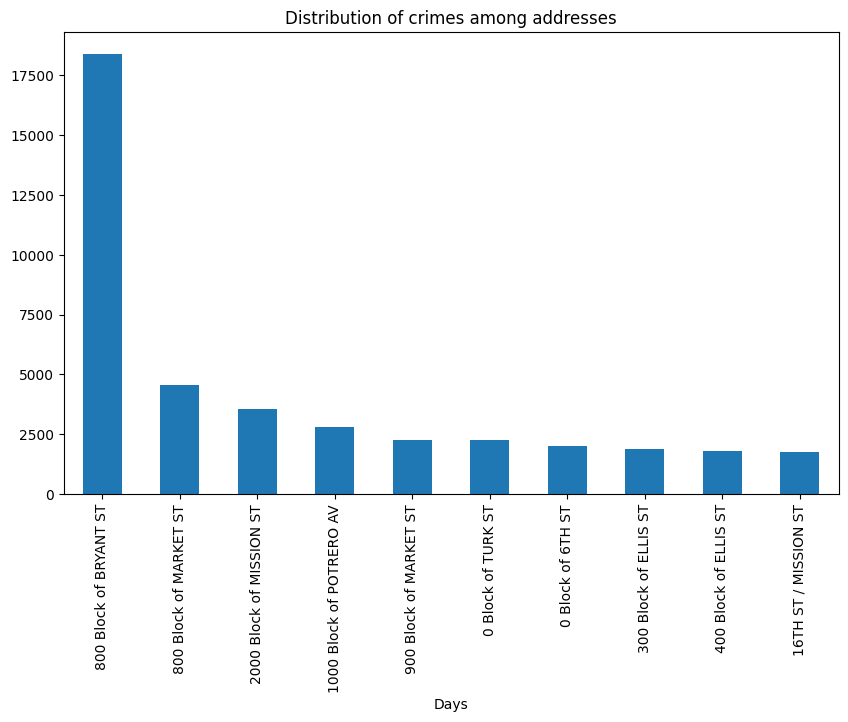

In [24]:
def crime_distribution_among_addresses(df_top_10, plot = True):
    if plot:
        df_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))
        plt.title('Distribution of crimes among addresses')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_addresses(sfcrime_train_top_10, plot = plot)

The graph shows that the higher number of crimes occur in addresses containing the word "_block_". This suggests that the presence of this word in an address may be a useful feature to extract when analyzing crime data.

One approach would be to **create a binary feature** representing the presence or absence of the word "block", setting it to 1 if the word appears in the address and 0 if it does not.

### How the crimes have been resolved?
The graph shows that most crimes have been solved with 'none'. This means that the majority of crimes have not yet been solved.

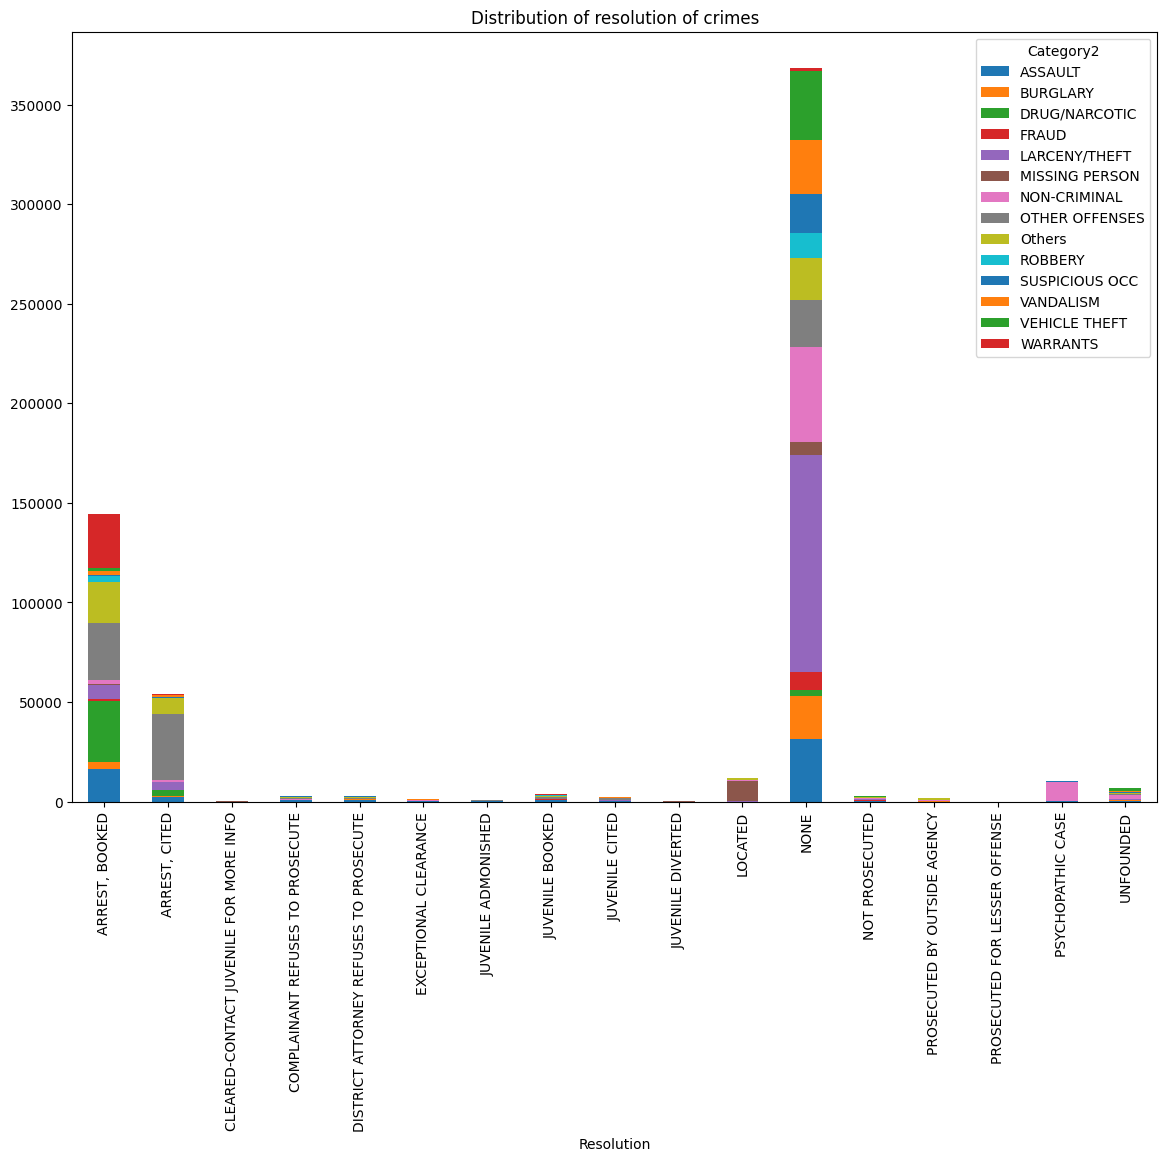

In [25]:
def crime_distribution_resolution(df, plot = True):
    if plot:
        cats_relevant = df['Category'].value_counts()[df['Category'].value_counts() > 10000].index
        df['Category2'] = df['Category'].apply(lambda x: 'Others' if x not in cats_relevant else x)
        df['Category2'].unique()

        df.groupby(['Resolution','Category2']).\
            agg({'PdDistrict':'count'}).\
            pivot_table(index='Resolution',columns='Category2')['PdDistrict'].\
            plot(kind='bar',stacked=True,figsize=(14,10))

        plt.title('Distribution of resolution of crimes')
        plt.show()

crime_distribution_resolution(sfcrime_train_pd, plot = plot)

## Re-process the dataset after having inspected it: 
- **Convert columns to categorical**: this improves memory usage and computational speed, ensures correct data interpretation and increases predictive accuracy.
- **String processing** pipeline: the 'Descript' column is composed of strings, its values are processed following two different pipelines for the _Bag-of-Word_ approach and the _TF-IDF_ approach 
- **Extract block feature** from the address (as explained in the dataset inspection).
- **Drop unused columns**

In [8]:
# Transform columns (PdDistrict, Category, Resolution, DayOfWeek) to categorical
district_indexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_cat")
category_indexer = StringIndexer(inputCol="Category", outputCol="Category_cat")
resolution_indexer = StringIndexer(inputCol="Resolution", outputCol="Resolution_cat")
day_indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_cat")

# Preprocess Descript column with tokenizer
regexTokenizer = Tokenizer(inputCol="Descript", outputCol="Descript_token")

# Bag of words approach: emphasizes word occurrence but doesn't consider their relative importance across the corpus and it treats all words equally within a document.
vectorizer = CountVectorizer(inputCol="Descript_token", outputCol="Descript_vec")

# TF-IDF approach: assigns higher weights to terms that are frequent in a document but rare in the corpus. 
hashingTF = HashingTF(inputCol="Descript_token", outputCol="Descript_tf", numFeatures=1000)
idf = IDF(inputCol="Descript_tf", outputCol="Descript_tfidf")

pipeline = Pipeline(stages=[regexTokenizer, vectorizer, district_indexer, category_indexer, resolution_indexer, day_indexer])
sfcrime = pipeline.fit(df_sfcrime).transform(df_sfcrime)

pipeline_tfidf = Pipeline(stages=[regexTokenizer, hashingTF, idf, district_indexer, category_indexer, resolution_indexer, day_indexer])
scrime_tfidf = pipeline_tfidf.fit(df_sfcrime).transform(df_sfcrime)

def drop_and_extract(sfcrime, approach = "bow"):
    
    # Block feature extraction: 1 if block present, 0 otherwise
    sfcrime = sfcrime.withColumn('Block', when(sfcrime.Address.like("%Block%") , lit(1)).otherwise(lit(0)))
    
    # Drop no more needed columns
    sfcrime = sfcrime.drop("PdDistrict")\
            .drop("Category")\
            .drop("DayOfWeek")\
            .drop("Resolution")\
            .drop("Descript")\
            .drop("Descript_token")\
            .drop("Address") # Drop the 'address' column since we already have (x, y) coordinates and the block feature
    
    if approach == "tfidf":
        sfcrime = sfcrime.drop("Descript_tf")
        
    return sfcrime

sfcrime = drop_and_extract(sfcrime)
sfcrime_tfidf = drop_and_extract(scrime_tfidf, approach = "tfidf")

In [9]:
# save sfcrime and sfcrime_tfidf
sfcrime.write.mode("overwrite").option("path", "bigdata/Project/dataset/sfcrime_processed").saveAsTable("sfcrime_processed")
sfcrime_tfidf.write.mode("overwrite").option("path", "bigdata/Project/dataset/sfcrime_tfidf_processed").saveAsTable("sfcrime_tfidf_processed")

23/12/31 12:20:03 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/12/31 12:20:08 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/12/31 12:20:08 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/12/31 12:20:08 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/12/31 12:20:08 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


In [3]:
# load sfcrime and sfcrime_tfidf
sfcrime = spark.table("sfcrime_processed")
sfcrime_tfidf = spark.table("sfcrime_tfidf_processed")

24/01/03 15:17:48 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/01/03 15:17:48 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/01/03 15:17:49 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/01/03 15:17:49 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.17.0.2


## Dataset requirements

In [4]:
print('Number of features: ', len(sfcrime.columns))

print('Total number of records: ', sfcrime.count())

print('Product of the number of features and the number of records: ', len(sfcrime.columns) * sfcrime.count())

Number of features:  11


Total number of records:  875659
Product of the number of features and the number of records:  9632249


# Models 

**EXAM**:
- Decision Tree -> #TODO: ricalcolare risultati perché erano stati fatti sul training
- Random forest -> #TODO: hyperparameter tuning + commento risultati rispetto a decision tree
- Naive Bayes -> OK
- Logistic Regression -> #TODO: hyperparameter tuning
- GBT classifier with One-vs-Rest -> OK

**PW**:
- MultiLayerPerceptron -> #TODO: check che va bene con scaled
- Logistic Regression  with TF-IDF -> #TODO: train e results + commento dei risulati wrt logistic regres precedente
- Factorization Machines with One-vs-Rest -> #TODO: fare con tutto il training set

da mettere? un po' ripetitivo 
- Logistic Regression with One-vs-Rest -> # TODO: hyperparameter tuning

FIX:
- pca (?)

### Prepare data for ML algorithms
- **RFormula**: it simplifies and standardizes the process of feature engineering, encodes categorical variables, and structures data for machine learning models, thereby streamlining the development and deployment of models within the Spark MLlib framework.
- **Standardize features**: standardization is an important step in many machine learning algorithms, especially those that involve distance-based metrics or gradient-based optimization, as it helps ensure that all features have a similar scale.
- **Train/Test split**
- **Repartition**: it helps in avoiding out-of-memory errors by distributing data evenly across partitions, preventing the overloading of resources on a single executor.
- Definition of an **evaluation function**: it calculates the *F1-score* and the *accuracy* for each model on the basis of the results obtained; in particular, it also calculates the _log-loss_ for those models that do not use the One-vs-Rest approach, since they do not return the 'probabilities' column, which is essential for calculating the log-loss.

In [4]:
rf = RFormula(formula="Category_cat ~ .")

# Bag of words approach
rf_transformed = rf.fit(sfcrime).transform(sfcrime)
rf_sfcrime = rf_transformed.selectExpr("features", "label")

# TF-IDF approach
rf_transformed = rf.fit(sfcrime_tfidf).transform(sfcrime_tfidf)
rf_sfcrime_tfidf = rf_transformed.selectExpr("features", "label")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
#rf_sfcrime_scaled = scaler.fit(rf_sfcrime).transform(rf_sfcrime) 
rf_sfcrime = scaler.fit(rf_sfcrime).transform(rf_sfcrime) #TODO: vedere se ok mettendo negli algoritmi 'feautes' al posto di 'scaledFeatures'

# Split the data into training and test sets (30% held out for testing)
(rf_sfcrime_train, rf_sfcrime_test) = rf_sfcrime.randomSplit([0.7, 0.3], seed=seed)
(rf_sfcrime_tfidf_train, rf_sfcrime_tfidf_test) = rf_sfcrime_tfidf.randomSplit([0.7, 0.3], seed=seed)
#(rf_sfcrime_scaled_train, rf_sfcrime_scaled_test) = rf_sfcrime_scaled.randomSplit([0.7, 0.3], seed=seed) #TODO: vedere se ok

# Repartition the data
rf_sfcrime_train = rf_sfcrime_train.repartition(100)
rf_sfcrime_tfidf_train = rf_sfcrime_tfidf_train.repartition(100)
#rf_sfcrime_scaled_train = rf_sfcrime_scaled_train.repartition(100) #TODO: vedere se ok

In [ ]:
rf_sfcrime_train.show()

In [5]:
def evaluation(results, model_name, oneVsRest = False):
    # Compute accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(results)
    print("Accuracy of model %s = %g" % (model_name, accuracy))

    # Compute F1 score
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(results)
    print("F1 score of model %s = %g" % (model_name, f1_score))
    
    # Compute logloss 
    if oneVsRest == False:
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="logLoss")
        log_loss = evaluator.evaluate(results)
        print("Log Loss of model %s = %g" % (model_name, log_loss))
    
        return accuracy, log_loss, f1_score
    
    return accuracy, f1_score     

# Exam

## Decision Tree Classifier
Decision trees are versatile machine learning algorithms that can be used for both binary and multi-label classification problems. Decision trees for multi-label classification have several advantages, including:
- Interpretability: Decision trees are often easy to interpret, as they can be represented as a series of rules or conditions. 
- Scalability: Decision trees can be used with large datasets, as they can be constructed efficiently using divide-and-conquer techniques.

However, they also have some limitations, including:
- Overfitting: Decision trees can easily overfit to the training data.
- Sensitivity to feature scaling: Decision trees can be sensitive to the scaling of features, as small changes in feature values can have a large impact on the model's predictions.

Despite these limitations, decision trees are a **powerful and versatile tool for multi-label classification**.

In order to select the best parameters for the DecisionTree Classifier we perform parameter tuning using **k- fold Cross Validation**, where the data is divided into k folds. The model is then trained on k-1 folds and evaluated on the remaining fold. This process is repeated k times, using different folds each time. The overall performance of the model is then estimated by averaging the performance scores from all k folds. This gives a more accurate estimate of the model's generalization performance than simply training the model on all of the data and evaluating it on a separate hold-out dataset.

The parameters we want to tune are *maxDepth* and *maxBins*. 

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", seed=seed)

# Define the grid of parameters to test
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [6, 8, 10]) \
                                .addGrid(dt.maxBins, [32, 128, 256]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel_dt = crossval.fit(rf_sfcrime_train) 

In [ ]:
# Evaluate the best model
best_dt_model = cvModel_dt.bestModel
best_maxdepth_param = best_dt_model.getOrDefault("maxDepth")
best_maxbins_param = best_dt_model.getOrDefault("maxBins")
print("Best maxDepth Parameter:", best_maxdepth_param)
print("Best maxBins Parameter:", best_maxbins_param) 

We found that the best parameters are:
- *maxDepth* = 10
- *maxBins* = 256

Now we can train the model and evaluate its performances.

In [15]:
dt_classifier = DecisionTreeClassifier(maxDepth=best_maxdepth_param, maxBins = best_maxbins_param, labelCol="label", featuresCol="features", seed=seed)
dt_Tr = dt_classifier.fit(rf_sfcrime_train)

results_dt_train = dt_Tr.transform(rf_sfcrime_train)

23/12/31 00:15:28 WARN MemoryStore: Not enough space to cache rdd_256_16 in memory! (computed 5.4 MiB so far)
23/12/31 00:15:28 WARN MemoryStore: Not enough space to cache rdd_256_17 in memory! (computed 5.4 MiB so far)
23/12/31 00:15:28 WARN MemoryStore: Not enough space to cache rdd_256_19 in memory! (computed 2.4 MiB so far)
23/12/31 00:15:28 WARN MemoryStore: Not enough space to cache rdd_256_18 in memory! (computed 3.6 MiB so far)
23/12/31 00:15:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_256_21 in memory.
23/12/31 00:15:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_256_22 in memory.
23/12/31 00:15:28 WARN MemoryStore: Not enough space to cache rdd_256_21 in memory! (computed 384.0 B so far)
23/12/31 00:15:28 WARN MemoryStore: Not enough space to cache rdd_256_22 in memory! (computed 384.0 B so far)
23/12/31 00:15:28 WARN BlockManager: Persisting block rdd_256_19 to di

In [16]:
# Evaluate the model
acc_dt, log_dt, f1_dt = evaluation(results_dt_train, 'Decision Tree')

'''                                                                                
Accuracy of model Decision Tree = 0.700701
[Stage 3032:===============================================>     (90 + 8) / 100]
F1 score of model Decision Tree = 0.705738
[Stage 3036:===============================================>     (89 + 8) / 100]
Log Loss of model Decision Tree = 1.00528
'''

Accuracy of model Decision Tree = 0.550081


F1 score of model Decision Tree = 0.476805


Log Loss of model Decision Tree = 1.46058


## Random forest
Random forests are particularly well-suited for multi-label classification because they are able to handle complex relationships between features and labels. They are also relatively robust to overfitting, making them a good choice for tasks with limited training data.

**Training Phase**:
- Build a random forest by constructing *multiple decision trees*.
- Each decision tree is trained on a randomly selected subset of features and labels from the training data.

**Prediction Phase**:
- For a new input instance, each decision tree in the forest makes a prediction for each label.
- The forest averages the predictions of all decision trees to determine the final prediction for each label.

Random forests are powerful and versatile machine learning algorithms that excel in multi-label classification problems. Their robustness to overfitting, ability to handle complex relationships, partial interpretability, and scalability make them well-suited for a wide range of applications.

To get the best results from the model, we use **cross-validation** to find the best parameters.

The parameters we want to optimize are _numTrees_, _maxDepth_ and _maxBins_.

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features") #scaledFeatures?

# Cross validation for Random Forest
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [50, 90, 120]) \
                                .addGrid(rf.maxDepth, [4, 6, 8]) \
                                .addGrid(rf.maxBins, [32, 128, 256]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel_rf = crossval.fit(rf_sfcrime_train)

# Evaluate the best model
best_rf_model = cvModel_rf.bestModel
best_numtrees_param = best_rf_model.getOrDefault("numTrees")
best_maxdepth_param = best_rf_model.getOrDefault("maxDepth")
best_maxbins_param = best_rf_model.getOrDefault("maxBins")
print("Best numTrees Parameter:", best_numtrees_param)
print("Best maxDepth Parameter:", best_maxdepth_param)
print("Best maxBins Parameter:", best_maxbins_param)

We found that the best parameters are:
- _numTrees_ = 
- *maxDepth* = 
- *maxBins* = 

Now we can train the model and evaluate its performances.

In [ ]:
rf_classifier = RandomForestClassifier(numTrees=best_numtrees_param, maxDepth=best_maxdepth_param, maxBins = best_maxbins_param, labelCol="label", featuresCol="features", seed=seed)
rf_Tr = rf_classifier.fit(rf_sfcrime_train)

results_rf = rf_Tr.transform(rf_sfcrime_test)

23/12/30 17:19:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_114_17 in memory.
23/12/30 17:19:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_114_18 in memory.
23/12/30 17:19:07 WARN MemoryStore: Not enough space to cache rdd_114_17 in memory! (computed 384.0 B so far)
23/12/30 17:19:07 WARN BlockManager: Persisting block rdd_114_17 to disk instead.
23/12/30 17:19:07 WARN MemoryStore: Not enough space to cache rdd_114_18 in memory! (computed 384.0 B so far)
23/12/30 17:19:07 WARN BlockManager: Persisting block rdd_114_18 to disk instead.
23/12/30 17:19:07 WARN MemoryStore: Not enough space to cache rdd_114_16 in memory! (computed 12.6 MiB so far)
23/12/30 17:19:07 WARN BlockManager: Persisting block rdd_114_16 to disk instead.
23/12/30 17:19:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_114_19 in memory.
23/12/30 17:19:07 

In [ ]:
# Evaluate the model
acc_rf, log_rf, f1_rf = evaluation(results_rf, 'Random Forest')

Accuracy of model Random Forest = 0.685567


F1 score of model Random Forest = 0.649056


Log Loss of model Random Forest = 1.76518


### TODO: change valori
In this case, random forest clearly outperforms decision trees, with an accuracy of 85% compared to 75%. This suggests that random forest is generally a better choice for this multi-label classification task.

## Naive Bayes

Naive Bayes is a probabilistic classification algorithm that is based on **Bayes' theorem** to calculate class probabilities based on observed features and prior probabilities. During the training phase it learns from data by computing class and feature probabilities, while in the prediction step it predicts the class for new instances by calculating posterior probabilities using learned probabilities.

It is a popular choice for multi-label classification because it is relatively simple to implement, interpretable, and scalable. However, it also has some limitations, such as the **strong independence assumption**, which can lead to inaccurate predictions, and the handling of rare features. Despite these limitations, Naive Bayes is a versatile and relatively efficient algorithm for multi-label classification. 

Firstly, we perform *hyperparameter tuning* in order to decide which smoothing parameter is the best for our purposes.

In [ ]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

# Define the grid of parameters to test
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 
cvModel_nb = crossval.fit(rf_sfcrime_train)

# Evaluate the best model
best_nb_model = cvModel_nb.bestModel
best_smoothing_param = best_nb_model.getOrDefault("smoothing")
print("Best Smoothing Parameter:", best_smoothing_param)

The best *smoothing parameter* turned out to be 0.0. 
This means that no smoothing needs to be applied to our model, presumably because the training data is large and diverse enough that the calculated probabilities are not affected by zero counts. We use this parameter to define and train the Naive Bayes model.

In [15]:
nb = NaiveBayes(modelType="multinomial", featuresCol="features", smoothing=best_smoothing_param)
nb_Tr = nb.fit(rf_sfcrime_train)

results_nb = nb_Tr.transform(rf_sfcrime_test)

In [17]:
# Evaluate the model
acc_nb, log_nb, f1_nb = evaluation(results_nb, 'Naive Bayes')

23/12/28 15:47:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy of model Naive Bayes = 0.988648


Log Loss of model Naive Bayes = 0.0653669


F1 score of model Naive Bayes = 0.989284


## Logistic Regression

Logistic regression is a statistical model that is used for binary classification but it can also be extended to handle multi-label classification problems, in this case it is known as _**Multinomial Logistic Regression**_. 

Logistic regression for multi-label classification typically follows a three-step process:

1. **Build Separate Models:** For each label, build a logistic regression model to predict the presence or absence of that label.

2. **Predict Probabilities:** For a new instance, calculate the probability of each label being present given the instance's features. This is done by using the logistic function to transform the linear combination of features into a probability between 0 and 1.

3. **Thresholding:** For each label, apply a threshold to the predicted probability to determine whether the label is predicted to be present or absent.

Overall, logistic regression is a versatile and well-established algorithm for multi-label classification. Its interpretability, scalability, and flexibility make it suitable for a wide range of applications. However, it is important to be aware of its limitations, such as the independent feature assumption and limited representation power, when choosing it for a specific task.

In this case we use Logistic Regression along with the *bag-of-words* approach, by vectorising the string features using the **CountVectorizer** which simply counts the number of times a word appears in a document.

Before starting to fit the model, we search for the best parameters to use for cross validation. In particular, we look for the following parameters: *maxIter*, *regParam* and *elasticNetParam*.

In [ ]:
lr = LogisticRegression(featuresCol="features", type="multinomial") #added multinomial

# Define the grid of parameters to test
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [10, 20, 30]) \
                                .addGrid(lr.regParam, [0.1, 0.3, 0.5]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel_lr = crossval.fit(rf_sfcrime_train)

# Evaluate the best model
best_lr_model = cvModel_lr.bestModel
best_maxiter_param = best_lr_model.getOrDefault("maxIter")
best_regparam_param = best_lr_model.getOrDefault("regParam")
best_elasticnetparam_param = best_lr_model.getOrDefault("elasticNetParam")
print("Best maxIter Parameter:", best_maxiter_param)
print("Best regParam Parameter:", best_regparam_param)
print("Best elasticNetParam Parameter:", best_elasticnetparam_param)

We found that the best parameters are:
- *maxIter* = 
- *regParam* = 
- *elasticNetParam* = 

Now we can train the model and evaluate its performances.

In [ ]:
lr = LogisticRegression(featuresCol="features", type="multinomial", maxIter=best_maxiter_param, regParam=best_regparam_param, elasticNetParam=best_elasticnetparam_param) #added multinomial
lr_Tr = lr.fit(rf_sfcrime_train)

results_lr = lr_Tr.transform(rf_sfcrime_test)

In [ ]:
# Evaluate the model
acc_lr, log_lr, f1_lr = evaluation(results_lr, 'Logistic Regression')

Accuracy of model Logistic Regression = 0.97992


Log Loss of model Logistic Regression = 0.509648


F1 score of model Logistic Regression = 0.974557


## Gradient-Boosted Tree classifier with One-vs-Rest

Gradient boosted trees (GBTs) are a type of ensemble learning algorithm that combines multiple decision trees to improve prediction accuracy. In multi-label classification, GBTs can be used to build a separate decision tree for each label. This approach is known as **one-vs-rest** (OVR) classification.

Gradient boosted trees can improve the performance of OVR classification by iteratively fitting decision trees to the residuals of previous predictions. This process helps to reduce the bias and variance of the overall model. Additionally, GBTs can handle complex relationships between features and labels, which can further improve performance.

The training time for Gradient Boosted Trees (GBT) can indeed be longer compared to simpler algorithms due to its sequential nature and the complexity of building multiple decision trees iteratively.

In [ ]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Instantiate the One Vs Rest Classifier 
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(rf_sfcrime_train)

results_gbtovr = ovrModel.transform(rf_sfcrime_test)

In [ ]:
# Evaluate the model
acc_gbtovr, f1_gbtovr = evaluation(results_gbtovr, 'Gradient-Boosted tree classififer with One vs Rest', oneVsRest = True)

In [ ]:
# Save results in json format to avoid recomputing them (it takes an hour)
results_gbtovr.write.json("bigdata/BDA/results_gbtovr.json")

In [ ]:
# Load the results from json file
results_lrovr = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/BDA/results_gbtovr.json/").load()

# Check that the results are loaded correctly
results_lrovr.show()

# Project Work

## MultiLayerPerceptron


A multilayer perceptron (MLP) is a type of **artificial neural network** that can be used for both binary and multi-label classification tasks.

MLPs for multi-label classification typically follow a four-step process:
- Input Layer: the input layer receives the features of an input instance.
- Hidden Layers: one or more hidden layers of neurons are used to learn the relationships between the input features and the labels.
- Output Layer: the output layer produces a vector of predictions for each label.
- Sigmoid Activation function: the sigmoid activation function is used to map the output of the neurons in the hidden layer to a probability between 0 and 1 for each label.

Using an MLP in multilabel classification allows for the learning of complex relationships between features and multiple labels simultaneously. However, it requires careful hyperparameter tuning, regularization, and handling of imbalanced data to build robust models for multilabel classification tasks.

In [21]:
# TODO: choose

# Compute input_size based on the assembled features
'''input_size = len(rf_sfcrime_scaled_train.select("features").first()[0])
# Compute the number of classes
output_size = len(rf_sfcrime_scaled_train.select("label").distinct().collect())'''

# Compute input_size based on the assembled features
input_size = len(rf_sfcrime_train.select("features").first()[0])

# Compute the number of classes
output_size = len(rf_sfcrime_train.select("label").distinct().collect())

In [7]:
# Specify layers for the neural network: input layer of size 1095 (features), one intermediate of size 100 and output of size 39 (classes)
layers = [input_size, 100, output_size]

# Train the model on scaled data since it performs gradient-based optimization
trainer = MultilayerPerceptronClassifier(featuresCol='scaledFeatures', maxIter=100, layers=layers, blockSize=32, seed=seed)

#TODO: choose

#model = trainer.fit(rf_sfcrime_scaled_train)
model = trainer.fit(rf_sfcrime_train)
results_mlp = model.transform(rf_sfcrime_test)

23/12/30 16:32:01 WARN MemoryStore: Not enough space to cache rdd_34_5 in memory! (computed 49.0 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_5 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_7 in memory! (computed 49.0 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_7 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_9 in memory! (computed 9.1 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_9 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_8 in memory! (computed 18.0 MiB so far)
23/12/30 16:32:02 WARN BlockManager: Persisting block rdd_34_8 to disk instead.
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_8 in memory! (computed 18.0 MiB so far)
23/12/30 16:32:02 WARN MemoryStore: Not enough space to cache rdd_34_7 in memory! (computed 49.0 MiB so far)
23/12/30 16:32:02 WARN Memo

In [9]:
# Evaluate the model
acc_mlp, log_mlp, f1_mlp = evaluation(results_mlp, 'MLP')

23/12/30 17:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB
23/12/30 17:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB


Accuracy of model MLP = 0.99955


23/12/30 17:07:26 WARN DAGScheduler: Broadcasting large task binary with size 1077.3 KiB


F1 score of model MLP = 0.999558


Log Loss of model MLP = 0.00117586


In [10]:
# Save the results
results_mlp.write.json("bigdata/BDA/results_mlp.json")

23/12/30 17:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1294.2 KiB


In [ ]:
# Load the results from json file
results_mlp = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/BDA/results_mlp.json/").load()

## Logistic regression with TF-IDF features

As already said, Logistic Regression can be extended to be used for multi-class classification problems. We can try to use it along with a different vectorization of the string features, namely **TF-IDF Vectorizer**, which takes into account the importance of a word across the entire corpus besides its frequency within a document

We use the same *hyperparameters* as in the previous fitting of the logistic regression in order to have more comparable results and to draw reliable conclusions about the best approach to use in this task to vectorise string features.

In [ ]:
# lr already defined with the best hyperparameters
lr_tfidf_Tr = lr.fit(rf_sfcrime_tfidf_train)

results_lr_tfidf = lr_tfidf_Tr.transform(rf_sfcrime_tfidf_test)

In [ ]:
# Evaluate the model
acc_lrtfidf, log_lrtfidf, f1_lrtfidf = evaluation(results_lr_tfidf, 'Logistic Regression with TF-IDF')

###TODO: COMMENTARE I RISULATI

## Factorization Machines with One-vs-Rest

Factorization Machines are a type of machine learning model that can be used to model the interactions between features. They are based on the assumption that the value of a label is determined not only by the individual features, but also by the interactions between those features.

Combining Factorization Machines with the One-vs-Rest strategy enables the model to predict the presence or absence of multiple labels for a given instance efficiently, in this way an FM model is used to learn the feature interactions and an OVR classifier is used to combine the predictions for each label.

In [ ]:
#keep only 100 records
#df_assembled = rf_sfcrime_scaled_train.limit(100)

# TODO: fare con tutto il dataset

df_assembled = rf_sfcrime_train.limit(100)

In [6]:
fm = FMClassifier(labelCol="label", featuresCol="scaledFeatures", maxIter=100, stepSize=1, seed=seed) # oppure step size= 0.001 

# Instantiate the One Vs Rest Classifier
ovr_fm = OneVsRest(classifier=fm)


# Create a Pipeline.
#pipeline = Pipeline(stages=[labelIndexer, featureScaler, fm])
 
# Train model. --> 16 minutes GIO
#model_fm = ovr_fm.fit(rf_sfcrime_scaled_train)


model_fm = ovr_fm.fit(rf_sfcrime_train)
results_fm = model_fm.transform(rf_sfcrime_test)

In [7]:
# Evaluate the model
acc_fm, f1_fm = evaluation(results_fm, 'Factorization Machines with One vs Rest', oneVsRest = True)

24/01/03 16:10:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


Accuracy of model Factorization Machines with One vs Rest = 0.996938


24/01/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


[3258.799s][warning][gc,alloc] stdout writer for python3: Retried waiting for GCLocker too often allocating 15434 words
[3258.799s][warning][gc,alloc] stdout writer for python3: Retried waiting for GCLocker too often allocating 256 words


24/01/03 16:11:47 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:47 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:47 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:47 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:48 WARN TaskMemoryManager: Failed to allocate a page (2917257 bytes), try again.
24/01/03 16:11:48 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:48 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:50 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:51 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:51 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:11:51 WARN TaskMemoryManager

[3269.829s][warning][gc,alloc] stdout writer for python3: Retried waiting for GCLocker too often allocating 21414 words


24/01/03 16:11:55 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
24/01/03 16:12:03 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.


F1 score of model Factorization Machines with One vs Rest = 0.997071


In [ ]:
# Save results
results_fm.write.json("bigdata/results_fm.json")

23/12/31 16:02:55 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/31 16:03:03 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:03 WARN TaskMemoryManager: Failed to allocate a page (2740698 bytes), try again.


[3404.729s][warning][gc,alloc] stdout writer for python3: Retried waiting for GCLocker too often allocating 342590 words


23/12/31 16:03:04 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:04 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:04 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:04 WARN TaskMemoryManager: Failed to allocate a page (2740698 bytes), try again.
23/12/31 16:03:05 ERROR Utils: Uncaught exception in thread stdout writer for python3
java.lang.OutOfMemoryError: Java heap space
Exception in thread "stdout writer for python3" java.lang.OutOfMemoryError: Java heap space
23/12/31 16:03:05 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:05 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:05 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 16:03:06 WARN TaskMemoryManager: Failed to allocate a page (4194288 bytes), try again.
23/12/31 1

In [ ]:
# Load the results from json file
results_fm = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/results_fm.json/").load()

## Logistic Regression with One-vs-Rest

In [ ]:
# TODO: hyperparameter tuning

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Instantiate the One Vs Rest Classifier
ovr = OneVsRest(classifier=lr)
ovrModel = ovr.fit(rf_sfcrime_train)

results_lrovr = ovrModel.transform(rf_sfcrime_test)

In [ ]:
# Evaluate the model
acc_lrovr, f1_lgovr = evaluation(results_lrovr, 'Logistic Regression classififer with One vs Rest', oneVsRest = True)

## Prova KNN

In [ ]:
#https://spark-packages.org/package/saurfang/spark-knn
#https://github.com/saurfang/spark-knn

In [19]:
'''from sparkknn.estimators import KNNClassifier
from pyspark.ml.feature import VectorAssembler

# Create the feature vector
assembler = VectorAssembler(inputCols=["X_Scaled", "Y_Scaled"], outputCol="features")
train_data = assembler.transform(sfcrime)
test_data = assembler.transform(sfcrime_test)

# Create the knn model
knn = KNNClassifier(k=10, topTreeSize=100, topTreeLeafSize=100)
knn_model = knn.fit(train_data)

# Make predictions
predictions = knn_model.transform(test_data)

predictions.select('prediction').show()'''

ModuleNotFoundError: No module named 'sparkknn'

# Error analysis

fare dataframe con tutti i risultati dei modelli

take the results from the best models and compute a multi class confusion matrix

In [1]:
#TODO

# PCA

In [65]:
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(rf_sfcrime_train)
sfcrime_pca_train = model.transform(rf_sfcrime_train)

#stessa trasformazione da applicare anche al validation?
#https://stats.stackexchange.com/questions/142216/zero-centering-the-testing-set-after-pca-on-the-training-set
sfcrime_pca_val = model.transform(rf_sfcrime_val)

In [66]:
sfcrime_pca_train.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|features                                                                                                                        |label|pca_features                             |
+--------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[9.0,7.0,2006.0,0.6219893339215445,0.6091207637881557,2.0,1.0,5.0,1.0,1.0,1.0,1.0])           |0.0  |[0.3683651146610864,-1886.54460884121]   |
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[15.0,1.0,2008.0,0.3525884499242813,0.670919143060952,9.0,1.0,1.0,1.0,1.0,1.0,1.0])           |0.0  |[-5.665206773112289,-1890.43784689985]   |
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[22.0,3.0,2006.0,0.6743842035748872,0.7117503097244482,4.0,3.0,7.0,1.0

In [ ]:
#TODO: provare a ripetere classification con PCA in tutti i modelli

##### Decision Tree

In [22]:
dt_classifier_pca = DecisionTreeClassifier()
dt_Tr_pca = dt_classifier_pca.fit(sfcrime_pca_train)
dt_Tr_pca = dt_Tr_pca.setFeaturesCol("features")

23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_15 in memory! (computed 1594.5 KiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_15 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_17 in memory! (computed 19.0 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_17 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_18 in memory! (computed 5.4 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_18 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_19 in memory! (computed 3.6 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_19 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_17 in memory! (computed 8.2 MiB so far)
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_18 in memory! (computed 19.0 MiB so far)
23/12/1

In [30]:
results_dt_pca = dt_Tr_pca.transform(sfcrime_pca_val)

In [27]:
results_dt_pca.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 29.0|      29.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



##### Naive Bayes

In [67]:
#Classification with NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_Tr = nb.fit(sfcrime_pca_train)

results_nb_val = nb_Tr.transform(sfcrime_pca_val)

In [68]:
results_nb_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
+-----+----------+
only showing top 20 rows



In [69]:
#evaluate the model
evaluation(results_nb_val, 'Naive Bayes with PCA')

Accuracy of model Naive Bayes with PCA = 0.988435


Log Loss of model Naive Bayes with PCA = 0.0654334


F1 score of model Naive Bayes with PCA = 0.989161


Commenti: i risultati sono esattamente gli stessi sia in termini di accuracy che di loss, anche settando diverse dimensioni per pca -> capire perchè succede

##### Logistic Regressor

In [70]:
#logistic regression with PCA
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(sfcrime_pca_train)

results_lr_val = lrModel.transform(sfcrime_pca_val)

In [71]:
results_lr_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [72]:
evaluation(results_lr_val, 'Logistic Regression with PCA')

Accuracy of model Logistic Regression with PCA = 0.97992


Log Loss of model Logistic Regression with PCA = 0.509648


F1 score of model Logistic Regression with PCA = 0.974557


##### Random forest

In [76]:
#random forest with PCA
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(sfcrime_pca_train)

results_rf_val = rfModel.transform(sfcrime_pca_val)

23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_1 in memory! (computed 100.2 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_1 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_3 in memory! (computed 12.6 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_3 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_2 in memory! (computed 12.6 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_2 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_0 in memory! (computed 66.3 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_0 to disk instead.
23/12/28 11:27:00 WARN MemoryStore: Not enough space to cache rdd_11347_1 in memory! (computed 155.5 MiB so far)
23/12/28 11:27:00 WARN MemoryStore: Not enough space to cache rdd_11347_3 in memory! (computed 29.4 MiB so

In [77]:
results_rf_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [78]:
evaluation(results_rf_val, 'Random Forest with PCA')

Accuracy of model Random Forest with PCA = 0.590899


Log Loss of model Random Forest with PCA = 1.82718


F1 score of model Random Forest with PCA = 0.554549


##### Gradient-Boosted tree with one-vs-rest

In [ ]:
#gradient boosted tree wth one vs rest
gbt = GBTClassifier(labelCol="label", featuresCol="pca_features", maxIter=10)
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(sfcrime_pca_train)

results_gbtovr = ovrModel.transform(sfcrime_pca_val)

In [ ]:
results_gbtovr.show()